# Temperature REX for the double-well model
For simplicity of implementation we do not run the replicas in parallel

In [1]:
from DoubleWell import *

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
import openmm
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

## run MD

In [4]:
#setup the system
dim = 2**6
n_temps = 6
T_low = 1 / kB
T_high = 5 / kB

modelMD = DoubleWellOpenMM(ModifiedWolfeQuapp(dim))

modelMD.dim, modelMD.MD_dim

(64, 66)

In [21]:
%%time
#setup and equilibrate

pace = 100
n_equil = 200
temperatures = np.geomspace(T_low, T_high, n_temps)

integrator = [openmm.LangevinMiddleIntegrator(T_low*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond)]
simulation = [openmm.app.Simulation(modelMD.topology, modelMD.system, integrator[-1])]
initial_pos = [modelMD.positions]
simulation[-1].context.setPositions(initial_pos[-1])
for temp in temperatures[1:]:
    print(f'sampling T = {temp*kB:.2f} ...', end='\r')
    integrator.append(openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond))
    simulation.append(openmm.app.Simulation(modelMD.topology, modelMD.system, integrator[-1]))
    simulation[-1].context.setPositions(initial_pos[-1])
    simulation[-1].step(n_equil*pace)
    initial_pos.append(simulation[-1].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers))
initial_pos = np.array(initial_pos)

with np.printoptions(precision=2):
    print('Temperatures:', temperatures * kB)
print()

Temperatures: [1.   1.38 1.9  2.63 3.62 5.  ]

CPU times: user 1.07 s, sys: 492 ms, total: 1.56 s
Wall time: 1.65 s


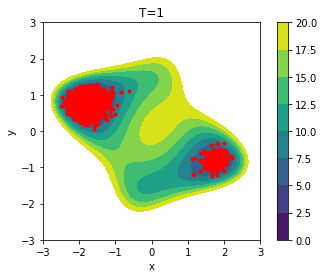

CPU times: user 3min 10s, sys: 37.3 s, total: 3min 48s
Wall time: 3min 1s


In [6]:
%%time
#sample 

pace = 100
n_iter = 10_000

is_swapped = np.full((n_temps,n_iter), False)
ener = np.full((n_temps, n_iter), np.nan)
data = np.full((n_temps, n_iter, 2), np.nan)
full_data = np.full((2, n_iter, *modelMD.positions.shape), np.nan)
for n in range(n_iter):
    for t in range(n_temps):
        simulation[t].step(pace)
        ener[t][n] = simulation[t].context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
        data[t][n] = np.array(simulation[t].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers))[0,:2]
        if t == 0 or t == 1:
            full_data[t][n] = simulation[t].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
    for tt in range(n%2, n_temps-1, 2):
        delta = -(1/(kB*temperatures[tt])-1/(kB*temperatures[tt+1]))*(ener[tt][n]-ener[tt+1][n])
        if delta <= 0.0 or np.random.rand() < np.exp(-delta):
            is_swapped[tt][n], is_swapped[tt+1][n] = True, True
            full_data_tt = simulation[tt].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
            full_data_tt1 = simulation[tt+1].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
            simulation[tt].context.setPositions(full_data_tt1)
            simulation[tt+1].context.setPositions(full_data_tt)
            simulation[tt].context.setVelocitiesToTemperature(temperatures[tt])
            simulation[tt+1].context.setVelocitiesToTemperature(temperatures[tt+1])
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plt.title(f'T={kB*temperatures[0]:g}')
        plot_doublewell(data[0][:n+1])
    print(f'sampling...  {(n+1)/n_iter:.1%}, accepted: {2*is_swapped[0].sum()/(n+1):.2%}', end='\r')

## check results

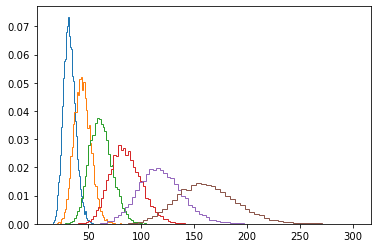

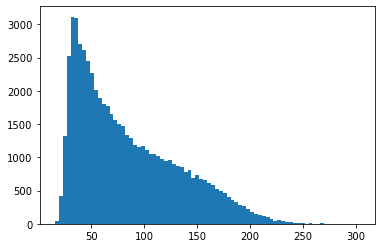

In [7]:
hist_opt = {'bins': 50, 'histtype': 'step', 'density': True}
for t in range(len(temperatures)):
    plt.hist(ener[t], **hist_opt, label=f'T={kB*temperatures[t]:g}')
# plt.legend()
plt.show()
plt.hist(ener.reshape(-1), bins='auto')
plt.show()

Acceptance rate: 19.86%
Useful exchanges: 6.647%


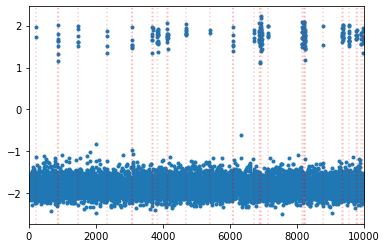

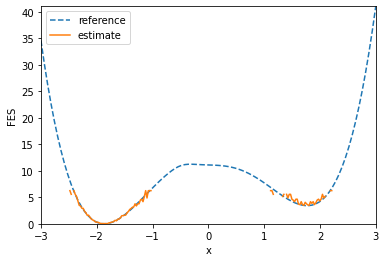

ref DeltaF: 3.31506 [kBT]
    DeltaF: 3.66356 [kBT]


In [8]:
print(f'Acceptance rate: {is_swapped[0].sum() / (n_iter // 2):.2%}')
diff = np.array(data[0,:,0]*data[1,:,0] < 0)
print(f'Useful exchanges: {diff[is_swapped[0]].sum() / is_swapped[0].sum():.3%}')
plt.plot(data[0,:,0],'.')
for sw in np.where(is_swapped[0])[0]:
    if diff[sw]:
        plt.axvline(sw, c='r', ls=':', alpha=.1)
plt.xlim(0, n_iter)
plt.show()
plot_fes(data[0,:,0])

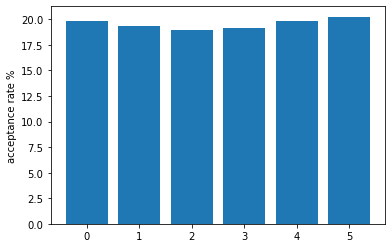

average acceptance: 19.58%


In [15]:
adjust_rate = np.ones(n_temps) #first and last replica try half of the exchanges
adjust_rate[0], adjust_rate[-1] = 2, 2
plt.bar(np.arange(n_temps), adjust_rate*[sw.sum() / n_iter * 100 for sw in is_swapped])
plt.ylabel('acceptance rate %')
plt.show()
print(f'average acceptance: {np.mean(adjust_rate*[sw.sum() / n_iter for sw in is_swapped]):.2%}')

In [10]:
efficiency = 1
for i in range(1, n_temps):
    logw = ener[i] / kB * (1 / temperatures[i] - 1 / temperatures[0])
    efficiency += bg.effective_sample_size(torch.as_tensor(logw)).item() / len(logw)
print(f'neigh efficiency: {(efficiency - 1):.2%}')
print(f'   tot efficiency: {efficiency / n_temps:.2%}')

neigh efficiency: 8.45%
   tot efficiency: 18.07%


In [11]:
# np.save(f'dw-REX-N{dim}', data[0,:,0])